# Fit one cell to the spatial Gaussian Process algorithm and evaluate the performance with the explained variance on a test set

In [1]:
import sys
import os
sys.path.append(os.path.abspath('./..'))
import time
import random
import csv
import numpy as np

import scipy.io
from scipy.io import loadmat

import torch
import pickle

from tqdm import tqdm
from tqdm import notebook

import matplotlib
import matplotlib.pyplot as plt

import importlib
import utils

# Enable autoreload
%load_ext autoreload
%autoreload 2
importlib.reload(utils)



TORCH_DTYPE = torch.float64 #NB: Basically all of the matrices in Spatial_GP have 1.e-7 added to the diagonal, to be changed if we want to use float64
torch.set_default_dtype(TORCH_DTYPE)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
torch.set_default_device(device)
print(f'Device is: {device}')

# Set seeds for reproducibility
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)  # if you are using multi-GPU.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

Using device: cuda:0 (from utils.py)
Using device: cuda:0 (from utils.py)
Device is: cuda:0


In [2]:
def load_stimuli_responses( dataset_path ):
    with open( dataset_path, 'rb') as file:
        loaded_data = pickle.load(file)
    # loaded_data is a Dataset object from module Data with attributes "images_train, _val, _test" as well as responses

    X_train = torch.tensor(loaded_data.images_train).to(device, dtype=TORCH_DTYPE) # shape (2910,108,108,1) where 108 is the number of pixels. 2910 is the amount of training points
    X_val   = torch.tensor(loaded_data.images_val).to(device, dtype=TORCH_DTYPE)
    X_test  = torch.tensor(loaded_data.images_test).to(device, dtype=TORCH_DTYPE)  # shape (30,108,108,1) # nimages, npx, npx

    R_train = torch.tensor(loaded_data.responses_train).to(device, dtype=TORCH_DTYPE) # shape (2910,41) 2910 is the amount of training data, 41 is the number of cells
    R_val   = torch.tensor(loaded_data.responses_val).to(device, dtype=TORCH_DTYPE)
    R_test  = torch.tensor(loaded_data.responses_test).to(device, dtype=TORCH_DTYPE)  # shape (30,30,42) 30 repetitions, 30 images, 42 cells

    return X_train, X_val, X_test, R_train, R_val, R_test

def load_multi_unit_responses(narutal_image_stimuli_pietro, natural_image_single_unit_train_dataset, natural_image_single_unit_test_dataset):

    with open( narutal_image_stimuli_pietro + "_train.npy", 'rb') as file:
        loaded_data = np.load(file)
        X = torch.tensor(loaded_data, dtype=TORCH_DTYPE)
        X_train = X[:2910]
        X_val   = X[2910:3160]
    
    with open( narutal_image_stimuli_pietro + "_test.npy", 'rb') as file:
        loaded_data = np.load(file)
        X_test  = torch.tensor(loaded_data, dtype=TORCH_DTYPE)

    with open( natural_image_single_unit_train_dataset, 'rb') as file:
        loaded_data_single_unit = np.load(file)
    # We upload the data and we create dummy training and validation sets
    R_train = torch.tensor(loaded_data_single_unit).to(device, dtype=TORCH_DTYPE)[:2910]    
    R_val   = torch.tensor(loaded_data_single_unit).to(device, dtype=TORCH_DTYPE)[2910:3160]

    with open( natural_image_single_unit_test_dataset, 'rb') as file:
        loaded_data_single_unit_test = np.load(file)

    R_test = torch.tensor(loaded_data_single_unit_test).to(device, dtype=TORCH_DTYPE)

    return X_train, X_val, X_test, R_train, R_val, R_test

def preprocess_dataset(X_train, X_val, R_train, R_val, R_test, select_cell=True, cellid=None):
    # Stacks the training and validation sets
    # Flatten images
    # Choose the cellid

    X = torch.cat( (X_train, X_val), axis=0,) 
    R = torch.cat( (R_train, R_val), axis=0,)

    n_px_side = X.shape[1]  

    # Reshape images to 1D vector and choose a cell
    X = torch.reshape(X, ( X.shape[0], X.shape[1]*X.shape[2])) 

    if select_cell:
        R = R[...,cellid] 
        R_test = R_test[...,cellid] 

    return X, R, R_test, n_px_side

def estimate_memory_usage(X, R):
    # Calculate memory usage for each tensor
    X_memory = X.element_size() * X.nelement()
    r_memory = R.element_size() * R.nelement()
    # Total memory usage in bytes
    total_memory_bytes = X_memory + r_memory
    # Convert bytes to megabytes (MB)
    total_memory_MB = total_memory_bytes / (1024 ** 2)
    print(f'Total dataset memory on GPU: {total_memory_MB:.2f} MB')
    return total_memory_MB

def get_idx_for_training_testing_validation(X, R, ntrain, ntilde, ntest_lk):
    
    # Generate training and testing sets for the fits. 
    # Especially useful for the active training setup

    # NB: Test set in this case is simply a subset of the original X and R.
    #     to allow the its use for performance comparison using the loglikelihood estimation.
    #     we call it test_lk set


    '''
    Args:
    X : torch.tensor shape (nimages, npx, npx)
        Stimuli
    R : torch.tensor shape (nimages, ncells)
        Responses

    ntrain : int
        Number of training points
    ntilde : int
        Number of inducing points
    ntest_lk : int
        Number of test points for the test loglikelihood estimation

    
    '''
    
    all_idx  = torch.arange(0, X.shape[0])                     # Indices of the whole dataset  
    all_idx_perm  = torch.randperm(all_idx.shape[0])           # Random permutation of the indices

    test_lk_idx   = all_idx_perm[:ntest_lk]                                    # These will be the indices of the test_lk set
    all_idx_perm  = all_idx_perm[~torch.isin( all_idx_perm, test_lk_idx )]     # Remove the test set indices from the permutation
    rndm_idx      = all_idx_perm[:]                                            # These will be the indices of the training. 

    # Choose the indices of the training set. This is overkill here, but in the active learning these indices are constantly changing
    in_use_idx    = rndm_idx[:ntrain]
    xtilde_idx    = in_use_idx[:ntilde] 
    remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )]

    # Set the starting set
    xtilde        = X[xtilde_idx,:]       # In the simplest case the starting points are all inducing points
    X_in_use      = X[in_use_idx,:]
    X_remaining   = X[remaining_idx,:]
    X_test_lk     = X[test_lk_idx,:]

    R_remaining   = R[remaining_idx]
    R_in_use      = R[in_use_idx]
    R_test_lk     = R[test_lk_idx]

    X_tuple = (xtilde, X_in_use, X_remaining, X_test_lk)
    R_tuple = (R_remaining, R_in_use, R_test_lk)
    idx_tuple = (xtilde_idx, in_use_idx, remaining_idx, test_lk_idx)

    return X_tuple, R_tuple, idx_tuple

def set_hyperparameters( X_in_use, R_in_use, n_px_side, theta=None, freeze_list=[]):
    # Set the hyperparameters of the model
    # If theta is None, the hyperparameters are set based on the STAs
    # If theta is not None, the hyperparameters are set based on the values in theta

    # In this code the learnt hyperparameters are the one in the dictionary 'theta'
    # One can set them direcly or let generate_theta() set them based on the training set STAs
    # To override the choice of generate_theta() just give theta as input 

    # If one wants to compare the hyperparemeters set in Matthews's / Samuels's code one has to set
    # logbetasam : and transform it to logbetaexpr with the function fromlogbetasam_to_logbetaexpr
    # logrhosam  : and transform it to logrhoexpr with the function fromlogrhosam_to_logrhoexpr
    # logsigma_0 : and transform it to sigma_0 exponetiating it

    # logbetaexpr = utils.fromlogbetasam_to_logbetaexpr( logbetasam=torch.tensor(5.5) )# Logbetaexpr in this code is equal to logbeta in Samuele's code. Samuele's code set logbeta to 5.5
    # logrhoexpr  = utils.fromlogrhosam_to_logrhoexpr( logrhosam=torch.tensor(5)) 

    # Set the gradient of the hyperparemters to be updateable 
    for key, value in theta.items():
    # to exclude a single hyperparemeters from the optimization ( to exclude them all just set nMstep=0)
        if key in freeze_list:
            continue
        theta[key] = value.requires_grad_()

    if theta is None:
        hyperparams_tuple = utils.generate_theta( x=X_in_use, r=R_in_use, n_px_side=n_px_side, display=True)
    else:
        hyperparams_tuple = utils.generate_theta( x=X_in_use, r=R_in_use, n_px_side=n_px_side, display=True, **theta)
    return hyperparams_tuple, theta

def set_f_params( logA, lambda0):
    # We are not learning the lambda0, since given an A there is a closed form for it that minimised the loss
    f_params = {'logA': logA, 'lambda0':lambda0}
    f_params['logA'] = f_params['logA'].requires_grad_()

    return f_params

def get_cell_STA(X, R, zscore=True):

    if X.device != 'cpu': X = X.cpu()
    if R.device != 'cpu': R = R.cpu()

    n_px_side = int(np.sqrt(X.shape[1]))

    if zscore:
        X_zsorted = scipy.stats.zscore(  X.numpy(), axis=0)    # Z-score the images
    STA = np.multiply( R[:,None], X_zsorted ).sum(axis=0) / R.sum()
    STA = STA.reshape(n_px_side,n_px_side)
    return STA

def plot_hyperparams_on_STA( fit_model, STA=None, ax=None, **kwargs):

    label = kwargs.get('label', None)
    center_color = kwargs.get('center_color', 'white')
    width_color  = kwargs.get('width_color', 'white')

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5,5)) 

    n_px_side = fit_model['fit_parameters']['n_px_side']
    
    # Eps_0 : Center of the receptive field
    center_idxs = torch.tensor([(n_px_side-1)/2, (n_px_side-1)/2])
    eps_0x_fit = fit_model['hyperparams_tuple'][0]['eps_0x']
    eps_0y_fit = fit_model['hyperparams_tuple'][0]['eps_0y']
    logbetaexpr_fit = fit_model['hyperparams_tuple'][0]['-2log2beta']

    eps_idxs_fit    = torch.tensor( [
        center_idxs[0]*(1+eps_0x_fit), 
        center_idxs[1]*(1+eps_0y_fit)
        ])

    # Beta : Width of the receptive field - Implemented by the "alpha_local" part of the C covariance matrix
    ycord, xcord = torch.meshgrid( torch.linspace(-1, 1, n_px_side), torch.linspace(-1, 1, n_px_side), indexing='ij') # a grid of 108x108 points between -1 and 1
    xcord = xcord.flatten()
    ycord = ycord.flatten()
    logalpha_fit    = -torch.exp( logbetaexpr_fit )*((xcord - eps_0x_fit)**2+(ycord - eps_0y_fit)**2  )
    alpha_local_fit =  torch.exp(logalpha_fit)    # aplha_local in the paper

    # Levels of the contour plot for distances [1sigma, 2sigma, 3sigma]
    # (x**2 + y**2) = n*sigma -> alpha_local = exp( - (n*sigma)^2 / (2*sigma^2) )
    levels = torch.tensor( [np.exp(-4.5), np.exp(-2), np.exp(-1/2) ])
    ax.contour( alpha_local_fit.reshape(n_px_side,n_px_side).cpu(), levels=levels.cpu(), colors=width_color, alpha=0.5)
    ax.scatter( eps_idxs_fit[0].cpu(),eps_idxs_fit[1].cpu(), color=center_color, s=30, marker="o", label=label, )

    if STA is not None:
        ax.imshow(STA, origin='lower')

## Parameters of the training


In [3]:
rand_xtilde = True # If True, xtilde (inducing points) are chosen randomly, if False, xtilde is chosen from the first ntilde images

# The following flags are used to decide which datasets we are using, whether spike sorted ones or single unit ones. 
# We can also train on the spike sorted and evaluate on the single unit ones, or the other way around.
multi_unit_training_flag = True
# multi_unit_training_flag = False
multi_unit_testing_flag = True
# multi_unit_testing_flag = False

cellid    = 31          # Choose cell    
electrode = 156         # Or electrode, if you want to fit on single unit data
threshold = 8           # If trainin on single unit, need to select the threshold multiplier used for spike detection

if electrode == 51:  cellid = 31 if multi_unit_training_flag or multi_unit_testing_flag else cellid
if electrode == 190: cellid = 24 if multi_unit_training_flag or multi_unit_testing_flag else cellid
if electrode == 156: cellid = 'None' if multi_unit_training_flag or multi_unit_testing_flag else cellid
if electrode == 87:  cellid = 'None' if multi_unit_training_flag or multi_unit_testing_flag else cellid
if electrode == 168: cellid = 'None' if multi_unit_training_flag or multi_unit_testing_flag else cellid

ntilde  = 250           # Number of xtilde
kernfun = 'acosker'     # Choose kernel function

nEstep      = 50         # Total number of E-steps iterations. Update on the variational parameters m and V, plus the parameters f_param of the link function
nFparamstep = 10         # Number of iterations for the update of the f params of the link function for EACH E-step iteration
nMstep      = 20         # Total number of M-steps iterations. Update on the Hyperparameters of the kernel function
maxiter     = 30         # Iterations of the optimization algorithm comprising M and E steps

lr_Mstep = 0.1 
lr_Fparamstep = 0.1

ntrain = 3160 # Implement ntrain=-1 to use all the data

## Import the dataset and preprocess 


torch.Size([3160, 11664])

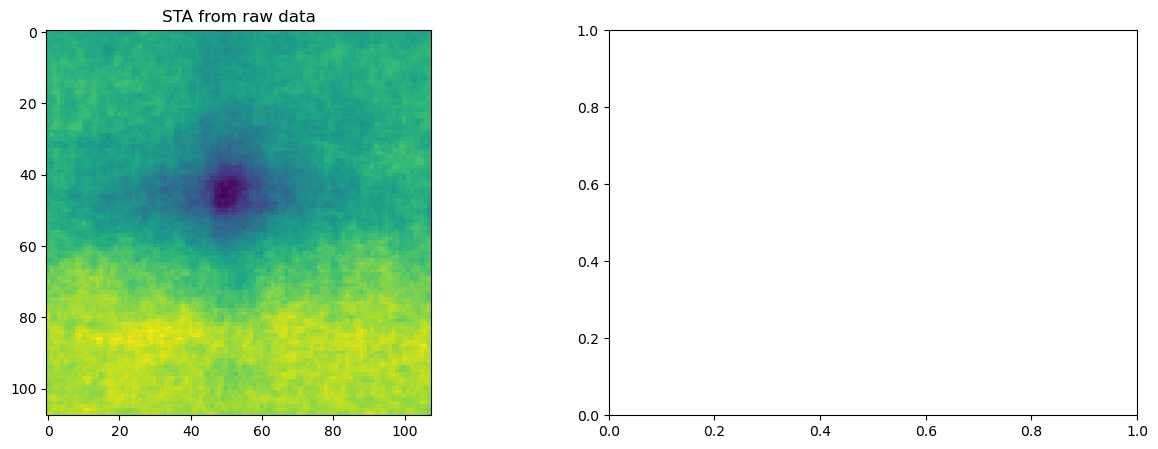

In [4]:


# natural_images_stimuli_preprocessed_train  = f"/home/idv-eqs8-pza/IDV_code/Experimental data/EXP17-data/processed_normalised_images_train.npy"
# natural_images_stimuli_preprocessed_test   = f"/home/idv-eqs8-pza/IDV_code/Experimental data/EXP17-data/processed_normalised_images_test.npy"
# natural_image_single_unit_train_dataset = f'/home/idv-eqs8-pza/IDV_code/Experimental data/EXP17-data/raw_electrode_datasets/electrode_{electrode}_set_train_R_raw_dataset_order_threshold_{threshold}.npy'
# natural_image_single_unit_test_dataset  = f'/home/idv-eqs8-pza/IDV_code/Experimental data/EXP17-data/raw_electrode_datasets/electrode_{electrode}_set_test_R_raw_threshold_{threshold}.npy'

X_train = np.load('/home/idv-eqs8-pza/IDV_code/Experimental data/EXP17-data/processed_normalised_images_train.npy')
X_test  = np.load('/home/idv-eqs8-pza/IDV_code/Experimental data/EXP17-data/processed_normalised_images_test.npy')
X_train = scipy.stats.zscore(  X_train, axis=0)
X_test  = scipy.stats.zscore(  X_test,  axis=0)

R_raw_train = np.load(f'/home/idv-eqs8-pza/IDV_code/Experimental data/EXP17-data/raw_electrode_datasets/electrode_{electrode}_set_train_R_raw_dataset_order_threshold_{threshold}.npy')

R_test = np.load(f'/home/idv-eqs8-pza/IDV_code/Experimental data/EXP17-data/raw_electrode_datasets/electrode_{electrode}_set_test_R_raw_threshold_{threshold}.npy')

sta_raw = np.multiply( R_raw_train[:,None,None], X_train[:,:,:,0] ).sum(axis=0) / R_raw_train.sum()

STA = sta_raw

fit , axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(sta_raw)
axes[0].set_title('STA from raw data')

n_px_side = 108


X = torch.tensor(X_train, dtype=TORCH_DTYPE)
R = torch.tensor(R_raw_train, dtype=TORCH_DTYPE)
X_test = torch.tensor(X_test, dtype=TORCH_DTYPE)
R_test = torch.tensor(R_test, dtype=TORCH_DTYPE)


X = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
X_tuple, R_tuple, idx_tuple  = get_idx_for_training_testing_validation(X, R, ntrain, ntilde, ntest_lk=0)

xtilde, X_in_use, X_remaining, X_test_lk           = X_tuple
R_remaining, R_in_use, R_test_lk                   = R_tuple
xtilde_idx, in_use_idx, remaining_idx, test_lk_idx = idx_tuple


X_in_use.shape
# endregion

In [5]:
# natural_images_sorted_dataset           = '/home/idv-eqs8-pza/IDV_code/Variational_GP/spatial_GP/Data/data2_41mixed_tr28.pkl'

# natural_images_stimuli_preprocessed     = f"/home/idv-eqs8-pza/IDV_code/Experimental data/EXP17-data/processed_normalised_images"
# natural_image_single_unit_train_dataset = f'/home/idv-eqs8-pza/IDV_code/Experimental data/EXP17-data/raw_electrode_datasets/electrode_{electrode}_set_train_R_raw_dataset_order_threshold_{threshold}.npy'
# natural_image_single_unit_test_dataset  = f'/home/idv-eqs8-pza/IDV_code/Experimental data/EXP17-data/raw_electrode_datasets/electrode_{electrode}_set_test_R_raw_threshold_{threshold}.npy'

# # region _____ Load data and reshape it ______
# X_train, X_val, X_test, R_train, R_val, R_test                   = load_stimuli_responses( natural_images_sorted_dataset )

# X_train_mu, X_val_mu, X_test_mu, R_train_mu, R_val_mu, R_test_mu = load_multi_unit_responses( natural_images_stimuli_preprocessed, natural_image_single_unit_train_dataset, 
#                                                                                              natural_image_single_unit_test_dataset)

# if multi_unit_training_flag:
#     # X, R, R_test, n_px_side  = preprocess_dataset(X_train, X_val, R_train_mu, R_val_mu, R_test_mu, select_cell=False )
#     # X, R = X_train, R_train_mu
#     # X = torch.reshape(X, ( X.shape[0], X.shape[1]*X.shape[2]))
# else:    
#     X, R, R_test, n_px_side  = preprocess_dataset(X_train, X_val, R_train, R_val, R_test, select_cell=True, cellid=cellid)
#     X, R = X_train, R_train
#     R = R[...,cellid]
#     X = torch.reshape(X, ( X.shape[0], X.shape[1]*X.shape[2]))

# X_tuple, R_tuple, idx_tuple  = get_idx_for_training_testing_validation(X, R, ntrain, ntilde, ntest_lk=0)

# xtilde, X_in_use, X_remaining, X_test_lk           = X_tuple
# R_remaining, R_in_use, R_test_lk                   = R_tuple
# xtilde_idx, in_use_idx, remaining_idx, test_lk_idx = idx_tuple

# STA = get_cell_STA(X, R, zscore=True)
# plt.imshow(STA)
# plt.suptitle(f'Sta of cell {cellid}')

# endregion

## Choose starting values of parameters

In [6]:
# Matthews params for cell 0

# logA    = torch.tensor(-2.1261)
# lambda0 = torch.tensor(-2.9697)

# sigma_0 = torch.tensor(0.6717)
# logbetaexpr = torch.tensor(5.2664)
# logrhoexpr  = torch.tensor(6.3228)
# Amp = torch.tensor(1.0) 
# eps_0x = torch.tensor(-0.0663)
# eps_0y = torch.tensor(-0.0066)

# theta_mat = {'sigma_0'  : sigma_0,     'Amp': Amp,
#         'eps_0x'    : eps_0x ,     'eps_0y'   : eps_0y, 
#         '-2log2beta': logbetaexpr, '-log2rho2': logrhoexpr }
# for key, value in theta_mat.items():
#     if key == 'Amp' or key == 'sigma_0':
#         continue
#     theta_mat[key] = value.requires_grad_()

# print('Matthews params for cell 0')
# utils.print_hyp(theta_mat)
# print('My fitted params for cell 0')
# utils.print_hyp(fit_model['hyperparams_tuple'][0])

Text(0.5, 0.98, 'STA of cell: None - Initial hyperparameters')

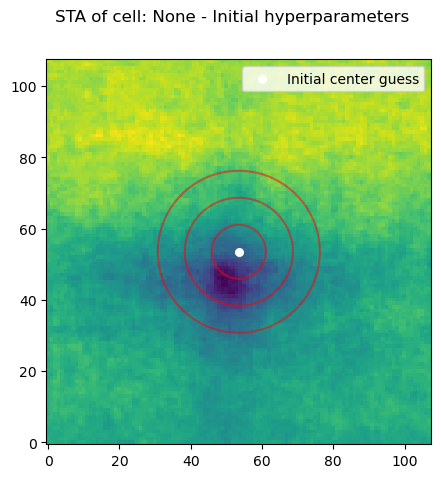

In [10]:
# region _____ Set starting params ______
beta = torch.tensor(0.1)
rho  = torch.tensor(0.1)

logbetaexpr = -2*torch.log(2*beta)
logrhoexpr  = -torch.log(2*rho*rho)

sigma_0 = torch.tensor(1.) # In Samueles code we set the log of sigma_0

Amp = torch.tensor(1.0)    # Not present in Matthews code

eps_0x = torch.tensor(-0.0001)
eps_0y = torch.tensor(+0.0001)

theta = {'sigma_0'  : sigma_0,     'Amp': Amp,   # Hypermarameters are expected to be 0-dimensional tensors
        'eps_0x'    : eps_0x ,     'eps_0y'   : eps_0y, 
        '-2log2beta': logbetaexpr, '-log2rho2': logrhoexpr }


A        = torch.tensor(0.01)
logA     = torch.log(A)
lambda0  = torch.tensor(1.)

hyperparams_tuple, theta = set_hyperparameters( X_in_use, R_in_use, n_px_side, theta=theta, freeze_list=['Amp'])
f_params = set_f_params( logA, lambda0)

# endregion

fit_parameters = {'ntilde':      ntilde,
                  'maxiter':     maxiter,
                  'nMstep':      nMstep,
                  'nEstep':      nEstep,
                  'nFparamstep': nFparamstep,
                  'kernfun':     kernfun,
                  'cellid':      cellid,
                  'n_px_side':   n_px_side,
                  'in_use_idx':  in_use_idx,     # Used idx for generating xtilde, referred to the whole X dataset
                  'xtilde_idx':  xtilde_idx,     # Used idx for generating the complete set, referred to the whole X dataset
                  'start_idx':   in_use_idx,   # Indexes used to generate the initial training set
                  'lr_Mstep':    lr_Mstep, 
                  'lr_Fparamstep': lr_Fparamstep
}

init_model = {
        'fit_parameters':    fit_parameters,
        'xtilde':            xtilde,
        'hyperparams_tuple': hyperparams_tuple,     # Contains also the upper and lower bounds for the hyperparameters
        'f_params':          f_params,
        # 'm':                 torch.zeros( (ntilde) )
        # 'm': torch.ones( (ntilde) )
        #'V': dont initialize V if you want it to be initialized as K_tilde and projected _exactly_ as K_tilde_b for stabilisation
    }

init_model['hyperparams_tuple'] = (theta, init_model['hyperparams_tuple'][1], init_model['hyperparams_tuple'][2])

# region _____ Hyperparameters choice plotted on the STA ______

initial_STA_fig, ax = plt.subplots(1, 1, figsize=(5,5)) 

# Eps_0 : Center of the receptive field
center_idxs = torch.tensor([(n_px_side-1)/2, (n_px_side-1)/2])
eps_idxs    = torch.tensor( [
    center_idxs[0]*(1+eps_0x), 
    center_idxs[1]*(1+eps_0y)
    ])

# Beta : Width of the receptive field - Implemented by the "alpha_local" part of the C covariance matrix
ycord, xcord = torch.meshgrid( torch.linspace(-1, 1, n_px_side), torch.linspace(-1, 1, n_px_side), indexing='ij') # a grid of 108x108 points between -1 and 1
xcord = xcord.flatten()
ycord = ycord.flatten()
logalpha    = -torch.exp( theta['-2log2beta']     )*((xcord - eps_0x)**2+(ycord - eps_0y)**2  )
alpha_local =  torch.exp(logalpha)    # aplha_local in the paper

# Levels of the contour plot for distances [1sigma, 2sigma, 3sigma]
# (x**2 + y**2) = n*sigma -> alpha_local = exp( - (n*sigma)^2 / (2*sigma^2) )
levels = torch.tensor( [np.exp(-4.5), np.exp(-2), np.exp(-1/2) ])
ax.contour( alpha_local.reshape(n_px_side,n_px_side).cpu(), levels=levels.cpu(), colors='red', alpha=0.5)
ax.scatter( eps_idxs[0].cpu(),eps_idxs[1].cpu(), color='white', s=30, marker="o", label='Initial center guess', )
# ax.imshow( alpha_local.reshape(n_px_side,n_px_side).cpu(),)
ax.imshow(STA, origin='lower')
ax.legend(loc='upper right')
initial_STA_fig.suptitle(f'STA of cell: {cellid} - Initial hyperparameters')

# endregion


## Fit the model
Also returns a tracking dictionary for important values

Initial Loss: 33158.9056
Loss iter 1: -31190.9628
 Mstep of iteration 1
Loss iter 2: -31439.9990
 Mstep of iteration 2
Loss iter 3: -31543.3707
 Mstep of iteration 3
Loss iter 4: -31609.4351
 Mstep of iteration 4
Loss iter 5: -31649.2132
 Mstep of iteration 5
Loss iter 6: -31667.6709
 Mstep of iteration 6
Loss iter 7: -31684.2066
 Mstep of iteration 7
Loss iter 8: -31697.2913
 Mstep of iteration 8
Loss iter 9: -31706.2337
 Mstep of iteration 9
Loss iter 10: -31713.6409
 Mstep of iteration 10
Loss iter 11: -31720.7863
 Mstep of iteration 11
Loss iter 12: -31726.2149
 Mstep of iteration 12
Loss iter 13: -31730.5835
 Mstep of iteration 13
Loss iter 14: -31734.9689
 Mstep of iteration 14
Loss iter 15: -31737.1467
 Mstep of iteration 15
Loss iter 16: -31740.3920
 Mstep of iteration 16
Loss iter 17: -31743.8488
 Mstep of iteration 17
Loss iter 18: -31745.8446
 Mstep of iteration 18
Loss iter 19: -31746.5522
 Mstep of iteration 19
Loss iter 20: -31747.3986
 Mstep of iteration 20
Loss iter 21:

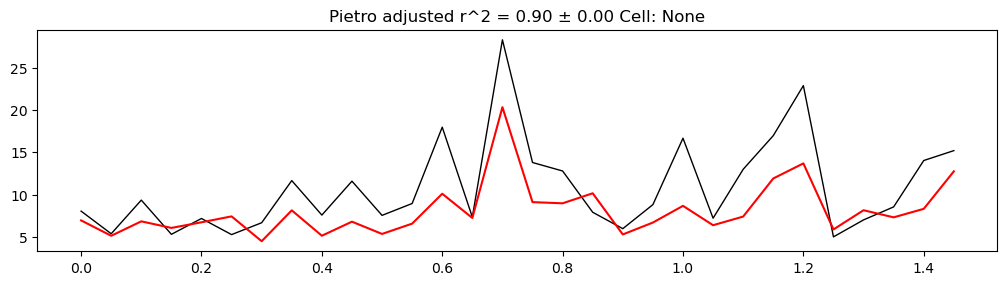

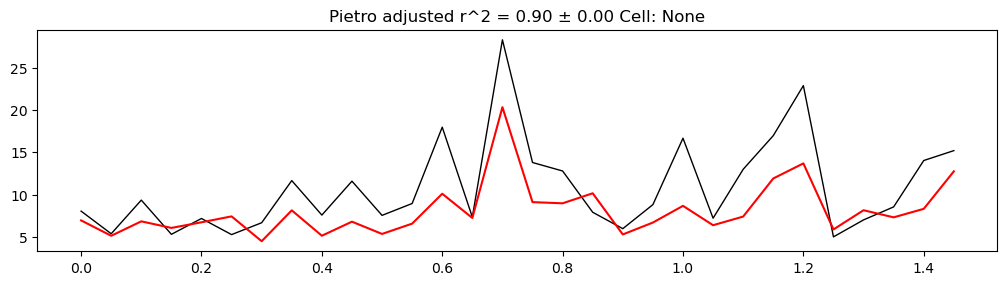

In [12]:
fit_model, err_dict = utils.varGP(X_in_use, R_in_use, **init_model)

if err_dict['is_error']:
    print('Error in the fit')
    raise err_dict['error']

# Save model
# with open('fit_model.pkl', 'wb') as file:
    # pickle.dump(fit_model, file)

# Load model
# with open('fit_model.pkl', 'rb') as file:
    # fit_model = pickle.load(file)

print(f' Electrode {electrode} - Cell {cellid}')
print(f'Initial:')
spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, X_train=X_in_use, at_iteration=0, **fit_model )

print(f'Final:')
spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, X_train=X_in_use, at_iteration=None, **fit_model )

utils.plot_fit(spk_count_pred, spk_count_test, r2, sigma_r2, cellid)

Initial Loss: 55208.4056
Loss iter 1: 1848.4246
 Mstep of iteration 1
Loss iter 2: 1712.2362
 Mstep of iteration 2
Loss iter 3: 1655.3413
 Mstep of iteration 3
Loss iter 4: 1600.9752
 Mstep of iteration 4
Loss iter 5: 1550.9208
 Mstep of iteration 5
Loss iter 6: 1505.4588
 Mstep of iteration 6
Loss iter 7: 1468.5409
 Mstep of iteration 7
Loss iter 8: 1437.2940
 Mstep of iteration 8
Loss iter 9: 1404.3739
 Mstep of iteration 9
Loss iter 10: 1379.7046
 Mstep of iteration 10
Loss iter 11: 1360.7984
 Mstep of iteration 11
Loss iter 12: 1341.5072
 Mstep of iteration 12
Loss iter 13: 1318.0389
 Mstep of iteration 13
Loss iter 14: 1301.9409
 Mstep of iteration 14
Loss iter 15: 1285.7572
 Mstep of iteration 15
Loss iter 16: 1271.9358
 Mstep of iteration 16
Loss iter 17: 1259.1352
 Mstep of iteration 17
Loss iter 18: 1250.3094
 Mstep of iteration 18
Loss iter 19: 1240.8476
 Mstep of iteration 19
Loss iter 20: 1231.1697
 Mstep of iteration 20
Loss iter 21: 1225.3313
 Mstep of iteration 21
Loss i

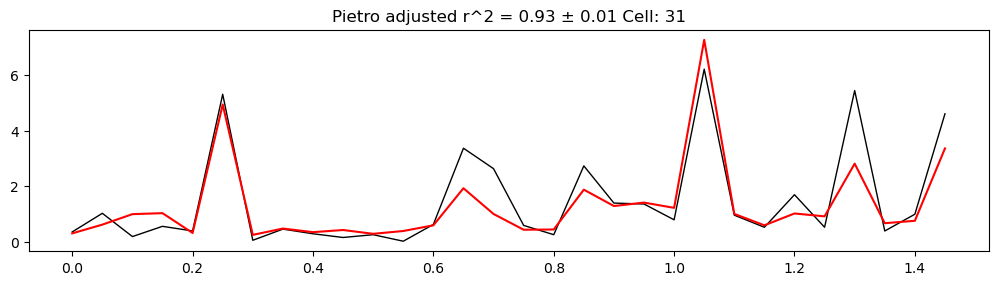

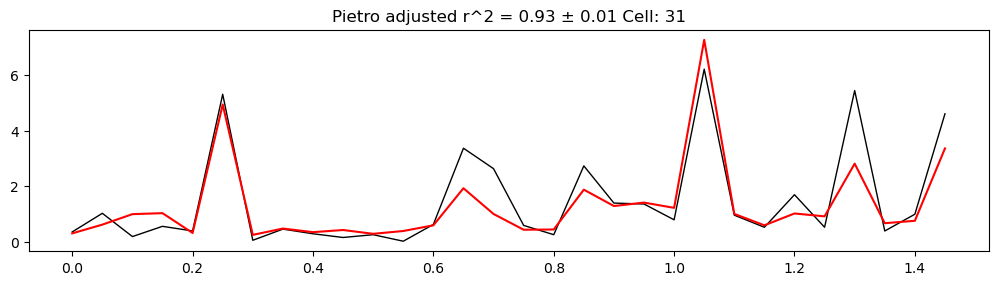

In [8]:
fit_model, err_dict = utils.varGP(X_in_use, R_in_use, **init_model)

if err_dict['is_error']:
    print('Error in the fit')
    raise err_dict['error']

# Save model
# with open('fit_model.pkl', 'wb') as file:
#     pickle.dump(fit_model, file)

# Load model
# with open('fit_model.pkl', 'rb') as file:
#     fit_model = pickle.load(file)

print(f'Initial:')
spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, X_train=X_in_use, at_iteration=0, **fit_model )

print(f'Final:')
spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, X_train=X_in_use, at_iteration=None, **fit_model )

utils.plot_fit(spk_count_pred, spk_count_test, r2, sigma_r2, cellid)

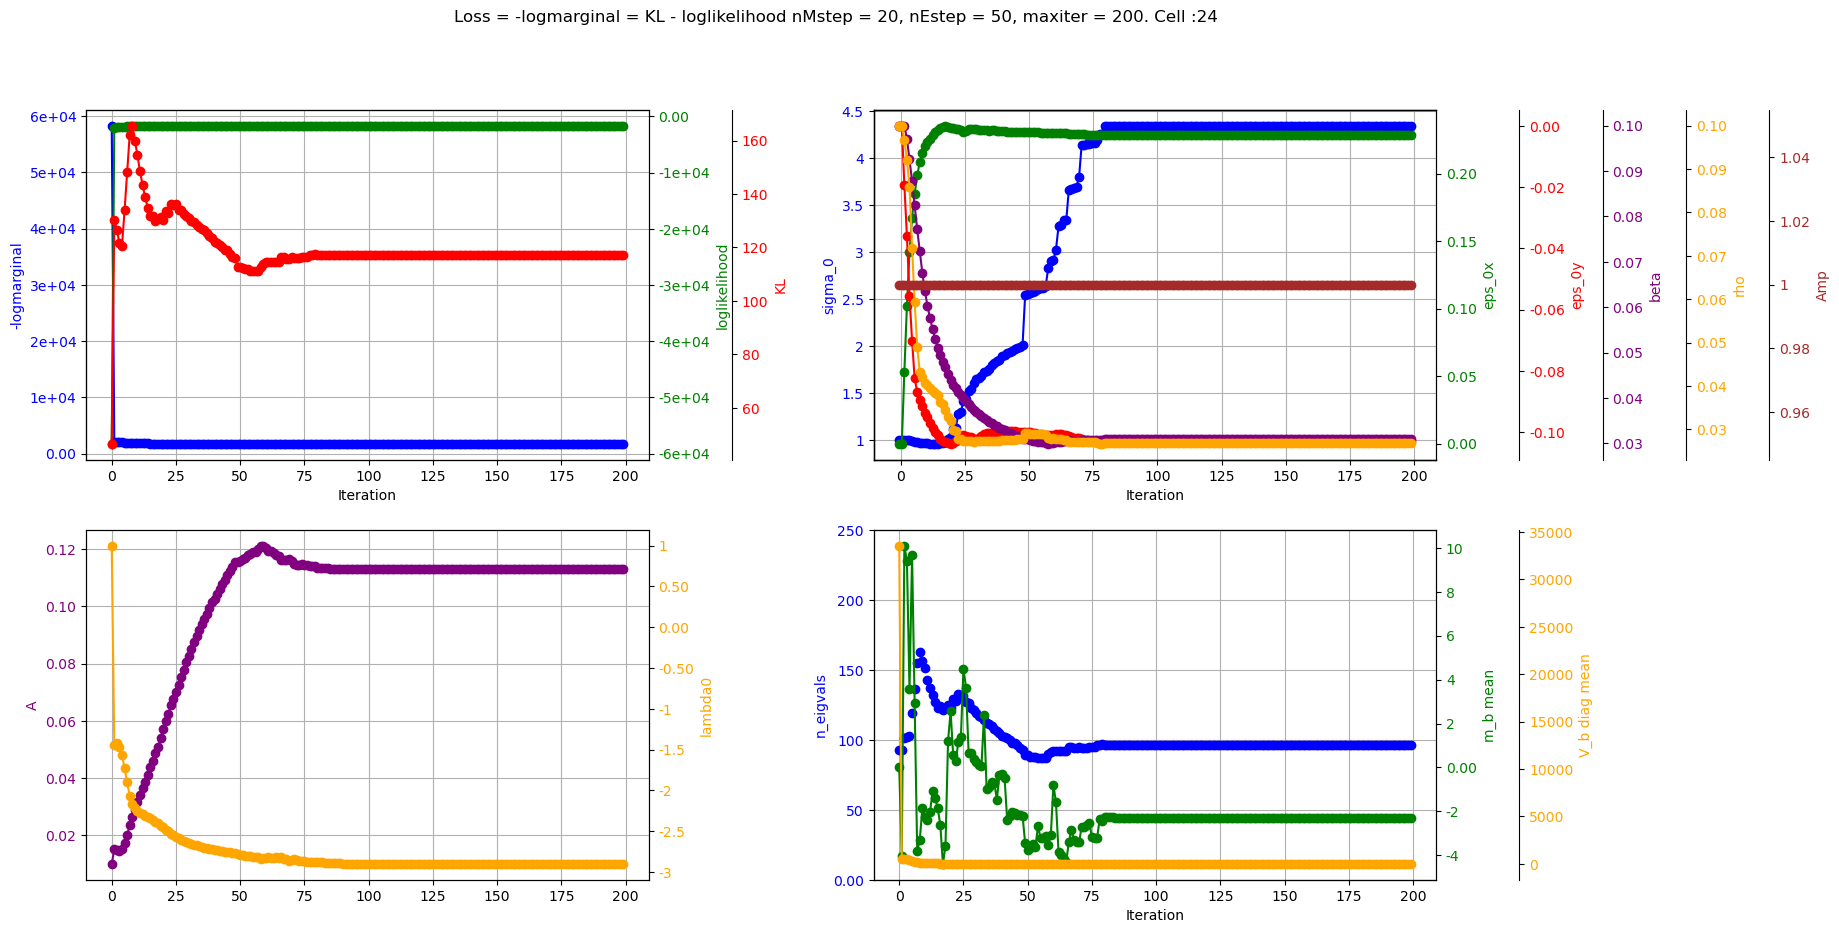

In [46]:

xlim = None
ylim_lambda0 = None
ylim_logmarg = None
utils.plot_loss_and_theta_notebook(fit_model, figsize=(15,10), xlim=xlim, ylim_lambda0=ylim_lambda0, marker='o', ylim_logmarg=ylim_logmarg)




Text(0.5, 0.98, 'Sta of cell: None with RF position')

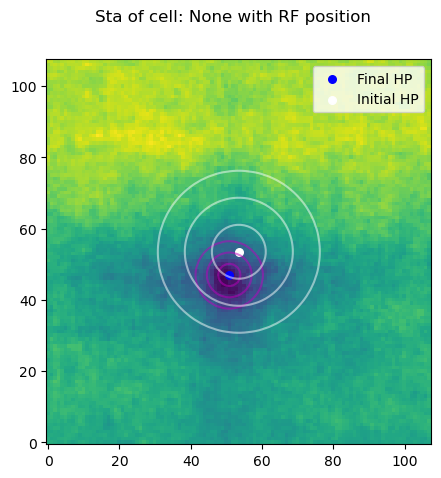

In [13]:
# region _____ Plot the final hyperparameters on the STA ______
# fig, ax = plt.subplots(1, 1, figsize=(5,5)) 

# final_eps_0x = fit_model['hyperparams_tuple'][0]['eps_0x']
# final_eps_0y = fit_model['hyperparams_tuple'][0]['eps_0y']

# center_idxs = torch.tensor([n_px_side/2, n_px_side/2])
# final_eps_idxs    = torch.tensor( [(n_px_side*final_eps_0x/2)+center_idxs[0], (n_px_side*final_eps_0y/2)+center_idxs[1]])

# ax.imshow(STA)
# ax.scatter( center_idxs[0].cpu(),center_idxs[1].cpu(), color='red', s=30, marker="x", label='Center', alpha=0.5)
# ax.scatter( final_eps_idxs[0].cpu(),final_eps_idxs[1].cpu(), color='blue', s=30, marker="x", label='Final center guess', )
# ax.scatter( eps_idxs[0].cpu(),eps_idxs[1].cpu(), color='white', s=30, marker="x", label='Initial center guess', )
# ax.legend(loc='upper right')
# fig.suptitle(f'Sta of cell {cellid} with initial hyperparameters')
# endregion

# region _____ Hyperparameters choice plotted on the STA ______


fig, ax = plt.subplots(1, 1, figsize=(5,5)) 
STA = get_cell_STA(X, R, zscore=True)

plot_hyperparams_on_STA( fit_model, STA, ax, center_color='blue', label='Final HP', width_color='m')
plot_hyperparams_on_STA( init_model, STA, ax, center_color='white', label='Initial HP', width_color='white')
ax.legend(loc='upper right')
fig.suptitle(f'Sta of cell: {cellid} with RF position')


# endregion


## Plot the Loss and Hyperparameters

`VarGP` returns a dictionary with the following structure:

- `fit_parameters`:
  - `maxiter`,
  - `nMstep`,
  - `nEstep`,
  - `kernfun`,
  - `cellid`,
  - `MIN_TOLERANCE`,
  - `EIGVAL_TOL`
  
- `values_track`:
  - `loss_track`:
    - `logmarginal`
    - `loglikelihood`
    - `KL`
  - `theta_track`:
    - `sigma_0`
    - `eps_0x`
    - `eps_0y`
    - `-2log2beta`
    - `-log2rho2`
    - `Amp`
  - `f_par_track`:
    - `logA`
    - `loglambda0`


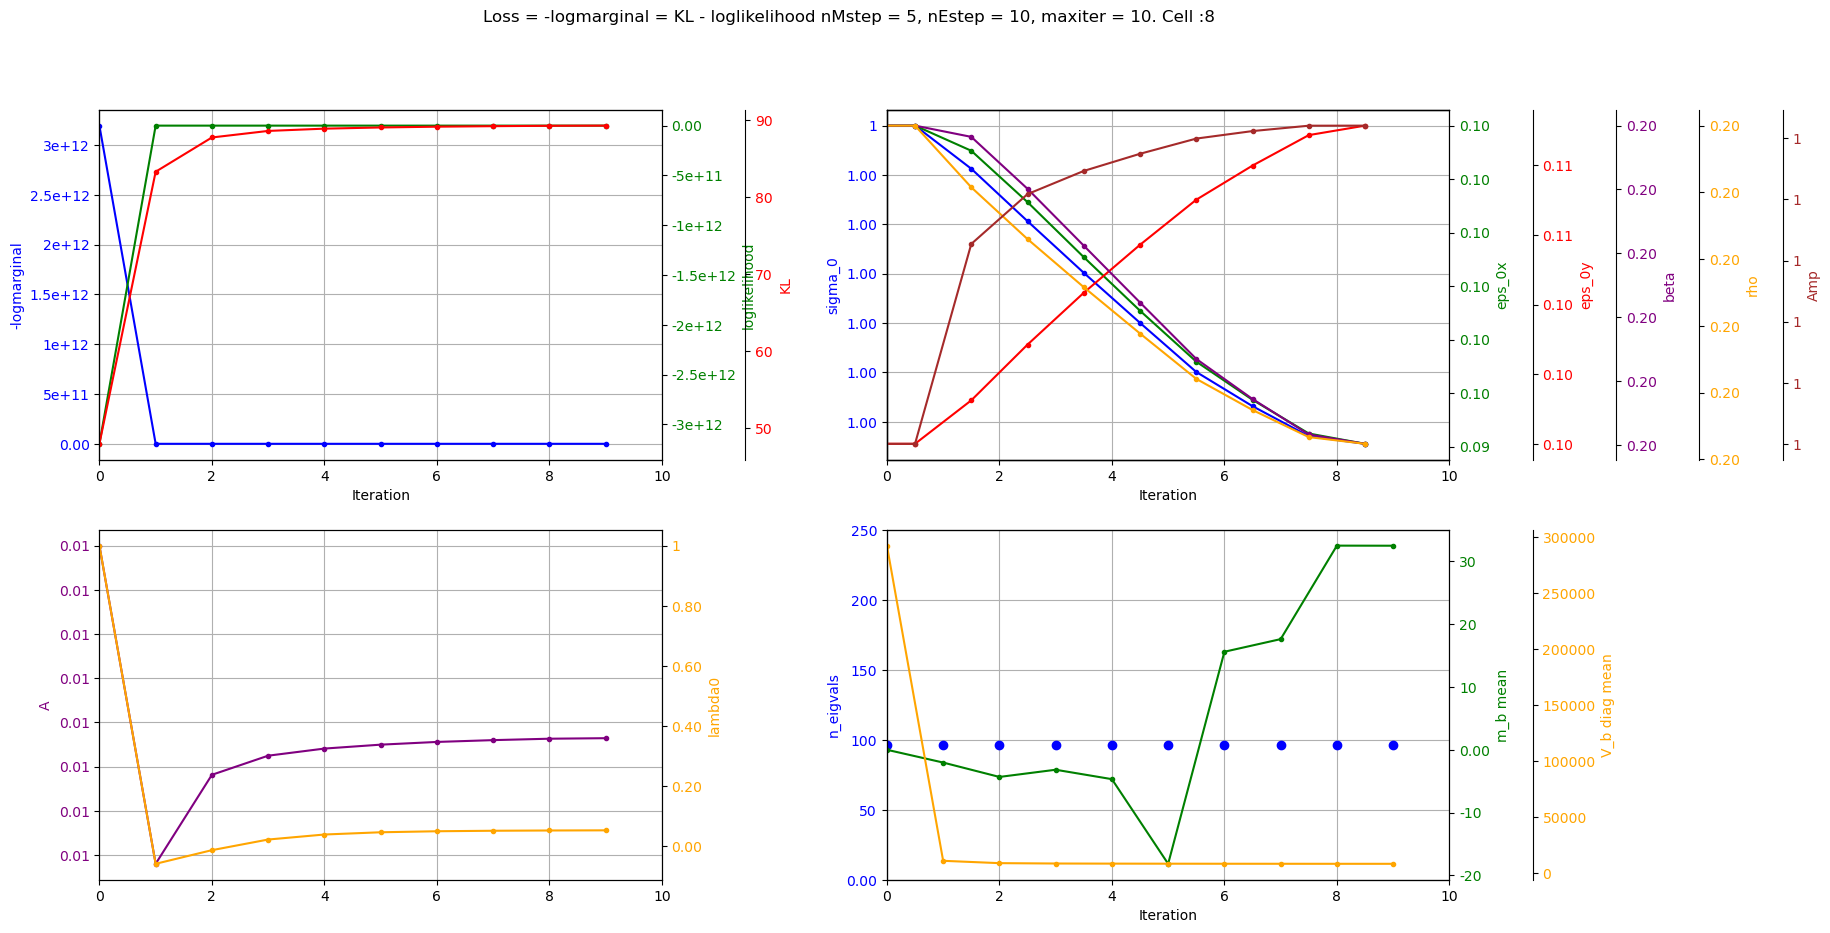

In [6]:
# fit_model = utils.load_model('models/cell8_Problem_ntilde:300_ntot:300_lrfparams:1')
xlim = None
xlim = (0, 10)
ylim_lambda0 = None
utils.plot_loss_and_theta_notebook(fit_model, figsize=(15,10), xlim=xlim, ylim_lambda0=ylim_lambda0, marker='.')#ylim_logmarg=(0, 5000))

## Evaluate the model on the test set using the explained variance and plot it



 Pietro's model: R2 = 0.14 ± 0.01 Cell: 0 maxiter = 10, nEstep = 50, nMstep = 0 



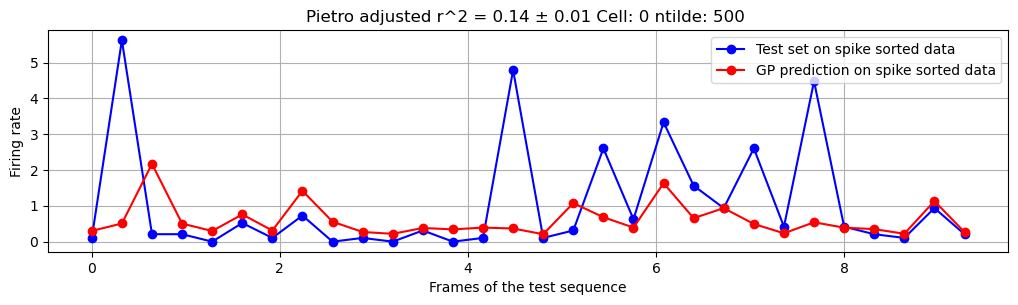

0.6947869383781292


In [6]:
# fit_model = utils.load_model('models/cell8_Problem_learninglambda_adjusted_iterations_ntilde:300_ntot:300_lrfparams:0.1')

# Predict and test
# spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, X_train=X, at_iteration=50, **fit_model )
spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test_cell, X_train=X, at_iteration=None, **fit_model )

spk_count_test = spk_count_test.cpu().numpy()
spk_count_pred = spk_count_pred.cpu().numpy()
r2             = r2.cpu().numpy()
sigma_r2       = sigma_r2.cpu().numpy()

spk_count_test = np.mean(spk_count_test, axis=0)

predict_window_ms = 320   # We are predicting the spike count of a 320 ms window ( from +30 to +350 ms since the stimulus onset )
f_rate_test_Hz    = spk_count_test/(predict_window_ms/1000) # Hz
f_rate_pred_Hz    = spk_count_pred/(predict_window_ms/1000) # Hz

# We plot the firing rate of the test set images as if they had been presented as a consetive sequence ( a video ) of one image each 320 ms
dt                = (predict_window_ms/1000)                # sec
time_values       = dt * np.arange( len(spk_count_pred) )   # sec

# Plot results after putting on cpu, numpy.
fig = plt.figure(figsize=(12, 8))
gs  = fig.add_gridspec(5, 5, left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.7)
ax  = fig.add_subplot(gs[3:, :])


ax.plot(time_values, f_rate_test_Hz, 'o-', color='green' if single_unit_testing_flag else 'blue', label=f'Test set on {"single unit" if single_unit_testing_flag else "spike sorted"} data')
ax.plot(time_values, f_rate_pred_Hz, 'o-', color='m' if single_unit_training_flag else 'red', label=f'GP prediction on {"single unit" if single_unit_training_flag else "spike sorted"} data')

# ax.errorbar(time_values, f_rate_pred_Hz / 0.05, yerr=np.sqrt(sigma2_f[:,0].cpu()) / 0.05, color='red')
# ax.legend(['data', 'GP'], loc='upper right', fontsize=14)
if single_unit_training_flag or single_unit_testing_flag:
    txt = f'Pietro adjusted r^2 = {r2:.2f} ± {sigma_r2:.2f} Electrode: {electrode} -> Cell {cellid}, ntilde: {ntilde} '
else:    
    txt = f'Pietro adjusted r^2 = {r2:.2f} ± {sigma_r2:.2f} Cell: {cellid} ntilde: {ntilde} '
ax.set_title(f'{txt}')
ax.set_ylabel('Firing rate')
ax.set_xlabel('Frames of the test sequence')
ax.grid(axis='both')
# plt.grid()
plt.legend()
plt.show()
plt.close()
print(spk_count_pred.max())



 Pietro's model: R2 = 0.63 ± 0.02 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 5 



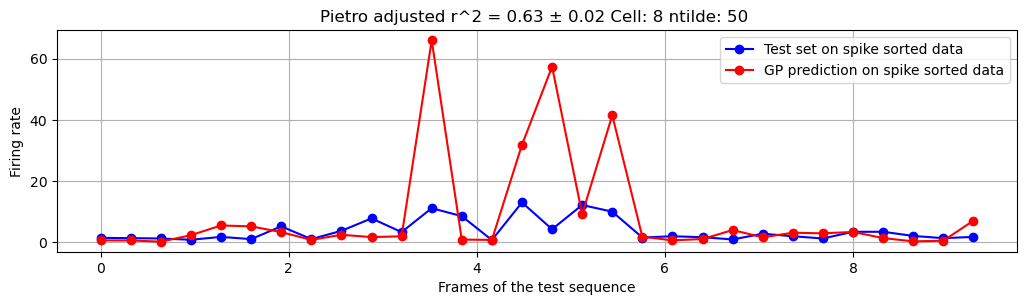

21.12180354765924


In [6]:
# fit_model = utils.load_model('models/cell8_Problem_learninglambda_adjusted_iterations_ntilde:300_ntot:300_lrfparams:0.1')

# Predict and test
# spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, X_train=X, at_iteration=50, **fit_model )
spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test_cell, X_train=X, at_iteration=None, **fit_model )

spk_count_test = spk_count_test.cpu().numpy()
spk_count_pred = spk_count_pred.cpu().numpy()
r2             = r2.cpu().numpy()
sigma_r2       = sigma_r2.cpu().numpy()

spk_count_test = np.mean(spk_count_test, axis=0)

predict_window_ms = 320   # We are predicting the spike count of a 320 ms window ( from +30 to +350 ms since the stimulus onset )
f_rate_test_Hz    = spk_count_test/(predict_window_ms/1000) # Hz
f_rate_pred_Hz    = spk_count_pred/(predict_window_ms/1000) # Hz

# We plot the firing rate of the test set images as if they had been presented as a consetive sequence ( a video ) of one image each 320 ms
dt                = (predict_window_ms/1000)                # sec
time_values       = dt * np.arange( len(spk_count_pred) )   # sec

# Plot results after putting on cpu, numpy.
fig = plt.figure(figsize=(12, 8))
gs  = fig.add_gridspec(5, 5, left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.7)
ax  = fig.add_subplot(gs[3:, :])


ax.plot(time_values, f_rate_test_Hz, 'o-', color='green' if single_unit_testing_flag else 'blue', label=f'Test set on {"single unit" if single_unit_testing_flag else "spike sorted"} data')
ax.plot(time_values, f_rate_pred_Hz, 'o-', color='m' if single_unit_training_flag else 'red', label=f'GP prediction on {"single unit" if single_unit_training_flag else "spike sorted"} data')

# ax.errorbar(time_values, f_rate_pred_Hz / 0.05, yerr=np.sqrt(sigma2_f[:,0].cpu()) / 0.05, color='red')
# ax.legend(['data', 'GP'], loc='upper right', fontsize=14)
if single_unit_training_flag or single_unit_testing_flag:
    txt = f'Pietro adjusted r^2 = {r2:.2f} ± {sigma_r2:.2f} Electrode: {electrode} -> Cell {cellid}, ntilde: {ntilde} '
else:    
    txt = f'Pietro adjusted r^2 = {r2:.2f} ± {sigma_r2:.2f} Cell: {cellid} ntilde: {ntilde} '
ax.set_title(f'{txt}')
ax.set_ylabel('Firing rate')
ax.set_xlabel('Frames of the test sequence')
ax.grid(axis='both')
# plt.grid()
plt.legend()
plt.show()
plt.close()
print(spk_count_pred.max())